# Pneumonia Identification Project

# Business and Data Understanding


# Data preparation

In [1]:
# For Google Colab only
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00


In [2]:
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import os

In [3]:
# Following code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"" ,
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [4]:
# Downloading and Importing images
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [155]:
# Linking directory path
train_data_dir = 'drive/MyDrive/chest_xray/train'
test_data_dir = 'drive/MyDrive/chest_xray/test'
val_data_dir = 'drive/MyDrive/chest_xray/val'

In [159]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=25,
                             fill_mode='nearest')

In [160]:
# Getting train and validation data from directory
train_generator = datagen.flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=5000)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(64, 64), batch_size=624)
val_generator = ImageDataGenerator().flow_from_directory(val_data_dir, target_size=(64, 64), batch_size=232)

Found 5000 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 232 images belonging to 2 classes.


In [161]:
# Creating datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [162]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(5000, 64, 64, 3)
(5000, 2)
(624, 64, 64, 3)
(624, 2)
(232, 64, 64, 3)
(232, 2)


In [163]:
# Reshaping data
train_img_unrow = train_images.reshape(5000,-1)
test_img_unrow = test_images.reshape(624,-1)
val_img_unrow = val_images.reshape(232,-1)

In [164]:
print(np.shape(train_img_unrow))
print(np.shape(test_img_unrow))
print(np.shape(val_img_unrow))

(5000, 12288)
(624, 12288)
(232, 12288)


In [165]:
# Normalizing data
train_img_final = train_img_unrow/255.0
test_img_final = test_img_unrow/255.0
val_img_final = val_img_unrow/255.0

# Modeling

In [112]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [113]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [114]:
# Function to quickly print out model evaluation for mulitple data sets
def model_evaluation(model, data_dict):
    """
    This function takes in a sequential model as a well as a dictionary of data and
    prints out the model evaluation results.

    Arguments:
    model: A trained model with .evaluate() capabilities
    data_dict: A dictionary where Keys are dataset names and Values are tuples (X, y) for data and labels.
    """
    for name, (X, y) in data_dict.items():
        loss, acc = model.evaluate(X, y)

        print(f'{name}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

In [115]:
# Creating dictionary for train, test, validation data
data_dict = {
    'Train Data': (train_images, train_labels),
    'Test Data': (test_images, test_labels),
    'Val Data': (val_images, val_labels)
}

In [116]:
# Creating dictionary for normalized train, test, validation data
data_dict_norm = {
    'Train Data': (train_img_final, train_labels),
    'Test Data': (test_img_final, test_labels),
    'Val Data': (val_img_final, val_labels)
}

In [166]:
model_1 = Sequential()

In [167]:
model_1.add(layers.Input(shape=(12288,)))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(2, activation='softmax'))

In [168]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [169]:
model_1_results = model_1.fit(train_img_final, train_labels,
                              epochs=10,
                              batch_size=125,
                              validation_data=(val_img_final, val_labels))

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7037 - loss: 0.9405 - val_accuracy: 0.5000 - val_loss: 0.7745
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7585 - loss: 0.4860 - val_accuracy: 0.5172 - val_loss: 0.7089
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8120 - loss: 0.4034 - val_accuracy: 0.7457 - val_loss: 0.5147
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8314 - loss: 0.3766 - val_accuracy: 0.7888 - val_loss: 0.4273
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8596 - loss: 0.3243 - val_accuracy: 0.6595 - val_loss: 0.5987
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8738 - loss: 0.2944 - val_accuracy: 0.8190 - val_loss: 0.3973
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8914 - loss: 0.2550 - val_accuracy: 0.7759 - val_loss: 0.4351
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8939 - loss: 0.2493 - val_accuracy: 0.7457 - val_loss

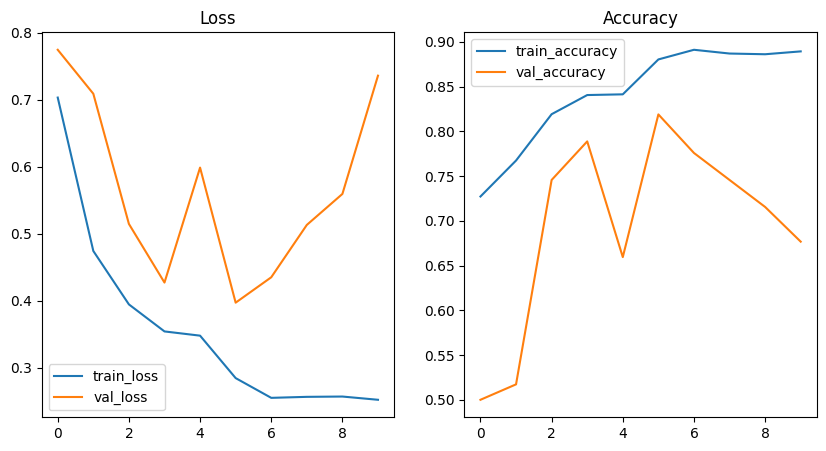

In [170]:
plot_results([model_1_results])

In [171]:
model_evaluation(model_1, data_dict_norm)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8428 - loss: 0.3793
Train Data, Loss: 0.3791, Accuracy: 0.8388
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6905 - loss: 0.7617
Test Data, Loss: 0.6993, Accuracy: 0.7147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5625 - loss: 1.1398
Val Data, Loss: 1.1398, Accuracy: 0.5625


In [172]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-5)

In [173]:
model_2 = Sequential()

In [174]:
model_2.add(layers.Input(shape=(12288,)))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(25, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(2, activation='softmax'))

In [175]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [176]:
model_2_results = model_2.fit(train_img_final, train_labels,
                              epochs=50,
                              batch_size=300,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[reduce_lr])

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.5420 - loss: 1.0374 - val_accuracy: 0.5000 - val_loss: 0.7289 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6723 - loss: 0.5769 - val_accuracy: 0.5474 - val_loss: 0.6014 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7264 - loss: 0.5199 - val_accuracy: 0.7586 - val_loss: 0.5159 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7721 - loss: 0.4797 - val_accuracy: 0.8017 - val_loss: 0.4652 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7922 - loss: 0.4566 - val_accuracy: 0.7457 - val_loss: 0.4787 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8175 - loss: 0.4155 - val_accuracy: 0.7284 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8380 - loss: 0.3901 - val_ac

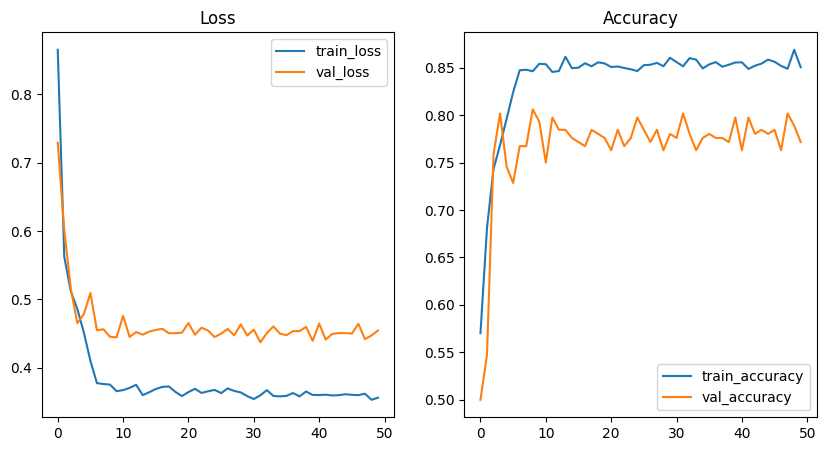

In [177]:
plot_results([model_2_results])

In [178]:
model_evaluation(model_2, data_dict_norm)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8749 - loss: 0.2989
Train Data, Loss: 0.2921, Accuracy: 0.8796
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8184 - loss: 0.4180
Test Data, Loss: 0.3991, Accuracy: 0.8269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6875 - loss: 0.6422
Val Data, Loss: 0.6422, Accuracy: 0.6875


In [179]:
model_3 = Sequential()

In [180]:
model_3.add(layers.Input(shape=(12288,)))
model_3.add(Dense(50, activation='relu'))
model_3.add(Dense(50, activation='relu', kernel_regularizer=l2))
model_3.add(Dropout(0.5))
model_3.add(Dense(25, activation='relu'))
model_3.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_3.add(Dropout(0.2))
model_3.add(Dense(10, activation='relu'))
model_3.add(Dense(2, activation='softmax'))

In [181]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [182]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [183]:
model_3_results = model_3.fit(train_img_final, train_labels,
                              epochs=40,
                              batch_size=350,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[reduce_lr, early_stop])

Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.6530 - loss: 7.6678 - val_accuracy: 0.5000 - val_loss: 7.0395 - learning_rate: 0.0010
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7253 - loss: 6.6976 - val_accuracy: 0.5000 - val_loss: 6.2294 - learning_rate: 0.0010
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7452 - loss: 5.8918 - val_accuracy: 0.5000 - val_loss: 5.5061 - learning_rate: 0.0010
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7495 - loss: 5.2882 - val_accuracy: 0.5000 - val_loss: 5.3538 - learning_rate: 2.0000e-04
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7514 - loss: 5.1450 - val_accuracy: 0.5000 - val_loss: 5.1987 - learning_rate: 2.0000e-04
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7591 - loss: 5.0290 - val_accuracy: 0.5000 - val_loss: 5.1826 - learning_rate: 4.0000e-05
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7482 - loss: 5.0

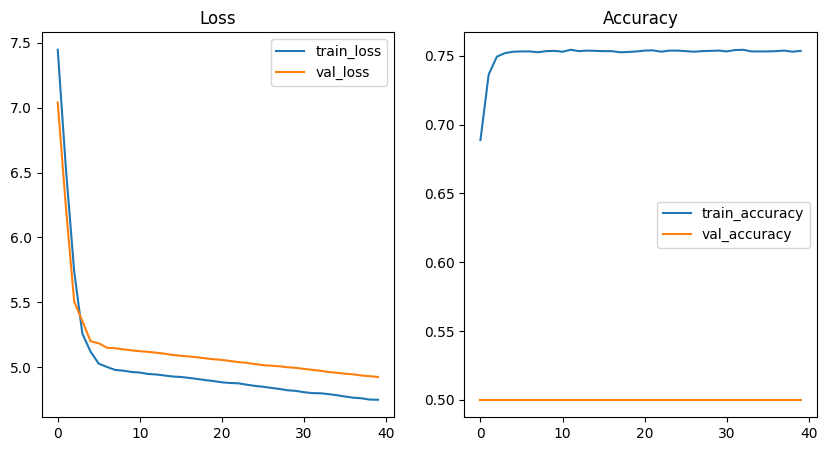

In [184]:
plot_results([model_3_results])

In [185]:
model_evaluation(model_3, data_dict_norm)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7493 - loss: 4.7294
Train Data, Loss: 4.7330, Accuracy: 0.7429
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6042 - loss: 4.8407
Test Data, Loss: 4.8243, Accuracy: 0.6250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5000 - loss: 5.0162
Val Data, Loss: 5.0162, Accuracy: 0.5000


In [186]:
model_4 = Sequential()

In [187]:
model_4.add(layers.Input(shape=(12288,)))
model_4.add(Dense(75, activation='relu'))
model_4.add(Dense(50, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.5)))
model_4.add(Dense(25, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_4.add(Dense(10, activation='relu', kernel_regularizer=l2(l2=0.01)))
model_4.add(Dense(2, activation='softmax'))

In [188]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [189]:
model_4_results = model_4.fit(train_img_final, train_labels,
                              epochs=50,
                              batch_size=250,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[early_stop])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7357 - loss: 30.7632 - val_accuracy: 0.5000 - val_loss: 25.9364
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7569 - loss: 24.3788 - val_accuracy: 0.5000 - val_loss: 20.5162
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7485 - loss: 19.2381 - val_accuracy: 0.5000 - val_loss: 16.2016
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7547 - loss: 15.1091 - val_accuracy: 0.5000 - val_loss: 12.7287
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7512 - loss: 11.8048 - val_accuracy: 0.5000 - val_loss: 9.9831
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7598 - loss: 9.1913 - val_accuracy: 0.5000 - val_loss: 7.8023
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7581 - loss: 7.1556 - val_accuracy: 0.6853 - val_loss: 6.1322
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8572 - loss: 5.5375 - val_accuracy: 0

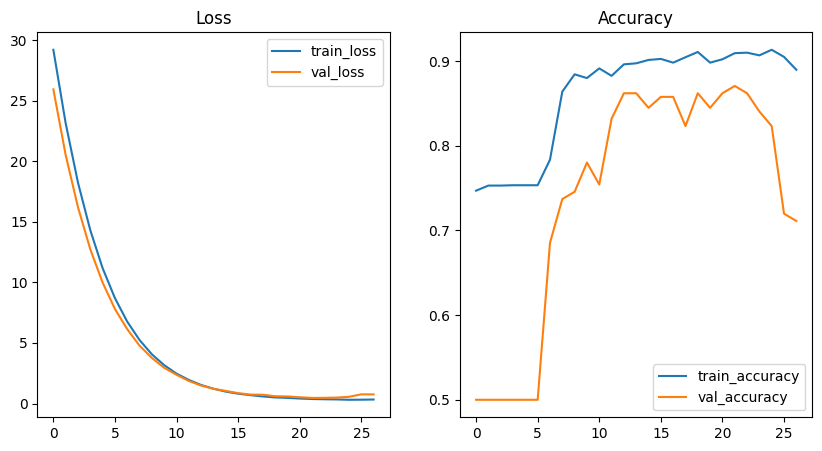

In [190]:
plot_results([model_4_results])

In [191]:
model_evaluation(model_4, data_dict_norm)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8902 - loss: 0.3854
Train Data, Loss: 0.3762, Accuracy: 0.8963
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8334 - loss: 0.5240
Test Data, Loss: 0.5035, Accuracy: 0.8429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6875 - loss: 0.7934
Val Data, Loss: 0.7934, Accuracy: 0.6875


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_lr=1e-5)

In [192]:
model_5 = models.Sequential()

In [193]:
model_5.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_5.add(layers.BatchNormalization())

model_5.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2=0.00001)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dropout(0.5))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))

model_5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid', kernel_regularizer=l2(l2=0.0001)))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Flatten())
model_5.add(layers.Dense(2, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [194]:
model_5.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

In [195]:
model_5_results = model_5.fit(train_images, train_labels,
                              epochs=20, batch_size=340,
                              validation_data=(val_images, val_labels),
                              callbacks=[early_stop])

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 664ms/step - accuracy: 0.5691 - loss: 0.7836 - val_accuracy: 0.7069 - val_loss: 0.6157
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8166 - loss: 0.4541 - val_accuracy: 0.5000 - val_loss: 0.7989
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8865 - loss: 0.2816 - val_accuracy: 0.6121 - val_loss: 0.6461
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8901 - loss: 0.2501 - val_accuracy: 0.5000 - val_loss: 0.8628
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9080 - loss: 0.2291 - val_accuracy: 0.6681 - val_loss: 0.5714
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9126 - loss: 0.2142 - val_accuracy: 0.6853 - val_loss: 0.5592
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9193 - loss: 0.1997 - val_accuracy: 0.5172 - val_loss: 0.7224
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9328 - loss: 0.1826 - val_accuracy: 0.8491 -

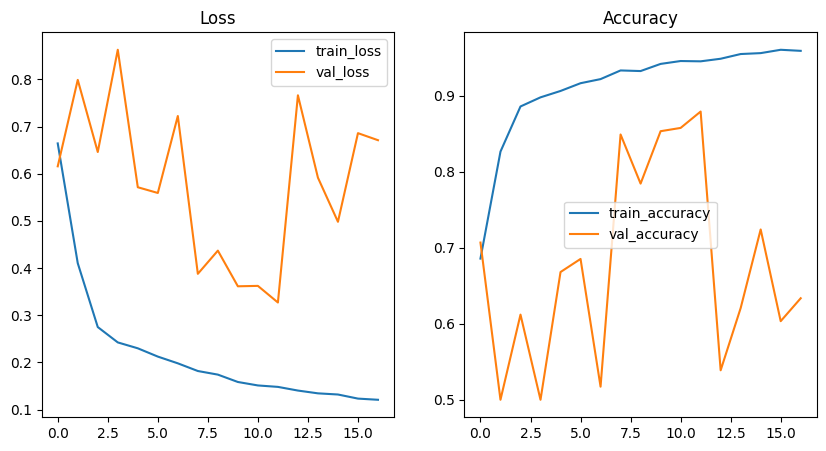

In [196]:
plot_results([model_5_results])

In [197]:
model_evaluation(model_5, data_dict)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9332 - loss: 0.2328
Train Data, Loss: 0.2298, Accuracy: 0.9360
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8260 - loss: 0.4163
Test Data, Loss: 0.4069, Accuracy: 0.8285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6875 - loss: 0.5263
Val Data, Loss: 0.5263, Accuracy: 0.6875


# Evaluation

In [296]:
final_model = Sequential()

In [297]:
final_model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3)))
final_model.add(layers.BatchNormalization())
final_model.add(layers.MaxPooling2D())

final_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
final_model.add(layers.BatchNormalization())

final_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2=0.00001)))
final_model.add(layers.BatchNormalization())
final_model.add(layers.Dropout(0.5))
final_model.add(layers.MaxPooling2D())

final_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))

final_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
final_model.add(layers.MaxPooling2D())

final_model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid', kernel_regularizer=l2(l2=0.000001)))
final_model.add(layers.Dropout(0.1))
final_model.add(layers.MaxPooling2D())

final_model.add(layers.Flatten())
final_model.add(layers.Dense(2, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [298]:
final_model.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

In [299]:
final_model_results = final_model.fit(train_images, train_labels,
                                      epochs=20,
                                      batch_size=340,
                                      validation_data=(val_images, val_labels),
                                      callbacks=[early_stop]
                                      )

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step - accuracy: 0.6019 - loss: 0.7007 - val_accuracy: 0.5043 - val_loss: 0.6960
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7915 - loss: 0.4814 - val_accuracy: 0.5345 - val_loss: 0.6547
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8618 - loss: 0.3145 - val_accuracy: 0.5172 - val_loss: 0.7275
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8922 - loss: 0.2500 - val_accuracy: 0.8233 - val_loss: 0.4380
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9063 - loss: 0.2250 - val_accuracy: 0.8405 - val_loss: 0.4258
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9151 - loss: 0.2124 - val_accuracy: 0.8405 - val_loss: 0.4178
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9204 - loss: 0.1967 - val_accuracy: 0.8448 - val_loss: 0.4221
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9236 - loss: 0.1953 - val_accuracy: 0.8621 -

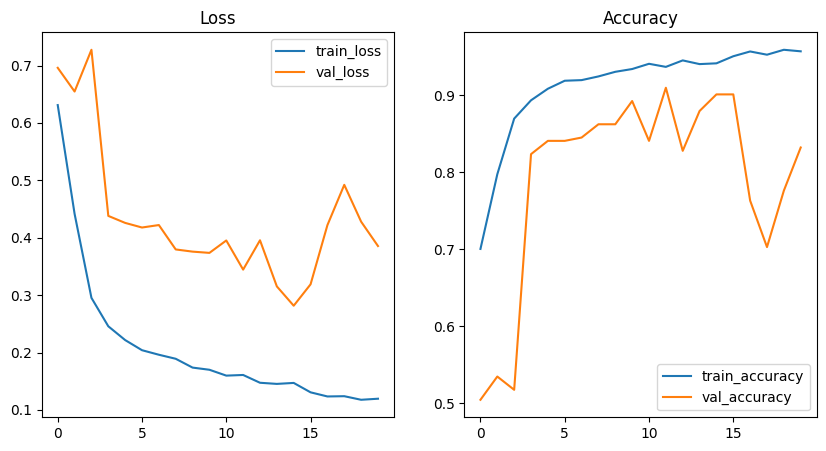

In [300]:
plot_results([final_model_results])

In [301]:
model_evaluation(final_model, data_dict)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8113 - loss: 0.3453
Train Data, Loss: 0.3512, Accuracy: 0.8060
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8275 - loss: 0.3749
Test Data, Loss: 0.3588, Accuracy: 0.8446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6875 - loss: 0.6019
Val Data, Loss: 0.6019, Accuracy: 0.6875


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


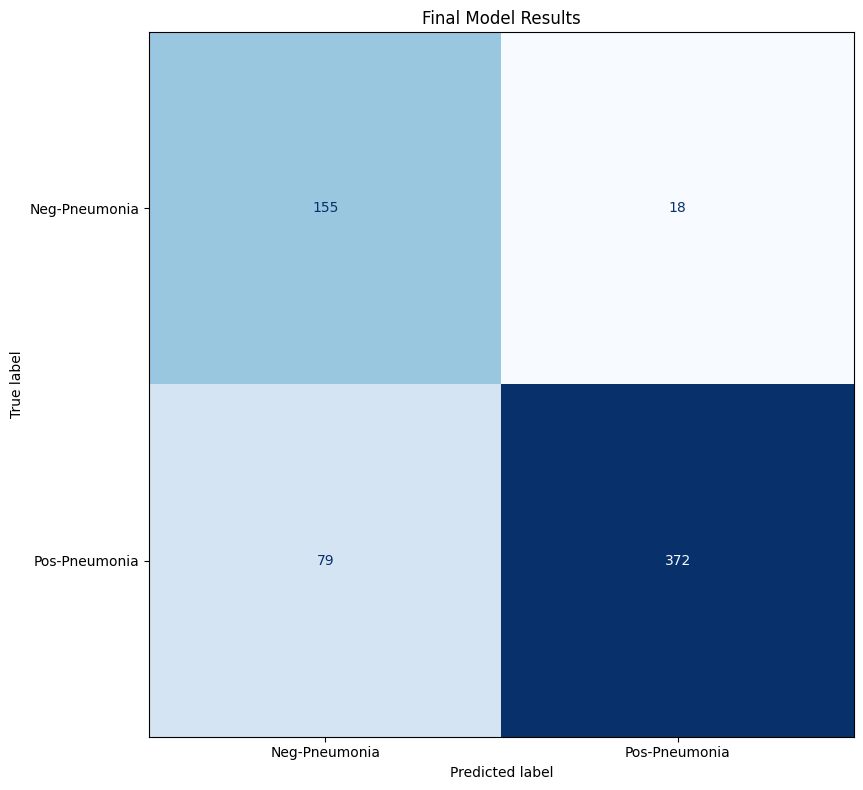

In [302]:
test_img_pred = final_model.predict(test_images)

# Confusion Matrix of final Model
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title('Final Model Results')

test_img_pred_labels = np.argmax(test_img_pred, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(test_img_pred_labels, test_true_labels)

ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=['Neg-Pneumonia', 'Pos-Pneumonia']).plot(ax=ax, cmap='Blues', colorbar=False)

plt.tight_layout();

# Limitations

# Next Steps

For some next steps, further model tweaks and parameter tuning may be necessary to improve the model overall performance. While an 86% is not terrible for accuracy with unseen test data, it does leave a little more to be desired especially with a loss of nearly .30 this tells us the model is missing the mark a little less than a third of the time.

Another potential next step if time permits would be using other Convolutional neural networks such as ResNet, DenseNet or ViT (Vision Transformers) image classification algorithms and comparing results to the current final model as the base model.